In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import norm


# 1) Cargamos nuestros datos

In [2]:
df_final_demo = pd.read_csv('df_final_demo.csv')
df_final_experiment_clients = pd.read_csv('df_final_experiment_clients.csv')
df_final_web_data_1 = pd.read_csv('df_final_web_data_pt_1.csv')
df_final_web_data_2 = pd.read_csv('df_final_web_data_pt_2.csv')


# 2) Unificación y renombrado de columnas web
Concatenamos las dos partes de datos web y renombramos a nombres claros: `visita_id`, `cliente_disp_id`, `estado_proceso`, `fecha_hora`.


In [3]:
# 2. Unificamos los df_web y renombramos columnas
df_final_web_data = pd.concat([df_final_web_data_1, df_final_web_data_2], ignore_index=True)
df_final_web_data = df_final_web_data.rename(columns={
    'visit_id'    : 'visita_id',
    'visitor_id'  : 'cliente_disp_id',
    'process_step': 'estado_proceso',
    'date_time'   : 'fecha_hora'
})



# 3) Tipos, rango temporal y orden lógico del proceso
Pasamos `fecha_hora` a datetime, filtramos al rango del experimento y definimos el orden del proceso (`start` → `confirm`). Ordenamos por visita y tiempo.


In [4]:
# 3) Tipos, rango temporal y orden lógico de pasos
df_final_web_data['fecha_hora'] = pd.to_datetime(df_final_web_data['fecha_hora'], errors='coerce')

# Rango del experimento
start_date = '2017-03-15'
end_date   = '2017-06-20'
df_final_web_data = df_final_web_data[
    (df_final_web_data['fecha_hora'] >= start_date) &
    (df_final_web_data['fecha_hora'] <= end_date)
].copy()

# Orden de proceso
orden_pasos = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
df_final_web_data['estado_proceso'] = pd.Categorical(
    df_final_web_data['estado_proceso'], categories=orden_pasos, ordered=True
)
df_final_web_data = df_final_web_data.sort_values(['visita_id', 'fecha_hora']).reset_index(drop=True)


# 4) Limpieza/renombre de demografía
Renombramos columnas de la tabla demográfica y convertimos a enteros seguros (`Int64`). Excluimos géneros no informativos.


In [5]:
# 4) Limpieza / renombre de la tabla demográfica
df_final_demo = df_final_demo.rename(columns={
    'clnt_tenure_yr'   : 'años_cliente_vg',
    'clnt_tenure_mnth' : 'meses_cliente_vg',
    'gendr'            : 'genero',
    'clnt_age'         : 'edad',
    'num_accts'        : 'num_cuentas',
    'calls_6_mnth'     : 'llamadas_6_meses',
    'logons_6_mnth'    : 'logins_6_meses',
    'bal'              : 'saldo_total'
})

def cambio_entero(df, cols):
    df = df.copy()
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').round().astype('Int64')
    return df

df_final_demo = cambio_entero(df_final_demo, [
    'años_cliente_vg','meses_cliente_vg','num_cuentas',
    'llamadas_6_meses','logins_6_meses','edad'
])

# Filtramos géneros poco informativos
df_final_demo_1 = df_final_demo.query("genero not in ['U','other','X']").copy()


# 5) Limpieza de clientes del experimento
Normalizamos el nombre de la columna `variation` y eliminamos filas nulas.


In [6]:
# 5) Limpieza de la tabla de experimento
df_final_experiment_clients = df_final_experiment_clients.rename(columns={'Variation': 'variation'}).dropna()
df_final_experiment_clients


,client_id,variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control
...,...,...
50495,393005,Control
50496,2908510,Control
50497,7230446,Test
50498,5230357,Test


# 6) Merges: web + experimento + demografía
Unimos los datos web con la asignación de experimento y, después, con demografía. Mostramos un pequeño chequeo de columnas y cobertura de `variation`.


In [7]:
# 6) Merges: web + experimento + demografía
web     = df_final_web_data
clients = df_final_experiment_clients
demo    = df_final_demo_1
web_clients = web.merge(clients[['client_id','variation']], on='client_id', how='left')
df_master = web_clients.merge(demo, on='client_id', how='left')
df_master


,client_id,cliente_disp_id,visita_id,estado_proceso,fecha_hora,variation,años_cliente_vg,meses_cliente_vg,edad,genero,num_cuentas,saldo_total,llamadas_6_meses,logins_6_meses
0,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:22:17,Test,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>
1,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:23:09,Test,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>
2,9056452,306992881_89423906595,1000165_4190026492_760066,start,2017-06-04 01:07:29,NaN,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>
3,9056452,306992881_89423906595,1000165_4190026492_760066,step_1,2017-06-04 01:07:32,NaN,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>
4,9056452,306992881_89423906595,1000165_4190026492_760066,step_2,2017-06-04 01:07:56,NaN,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747568,7149380,483112224_46340533900,999992932_41666455053_671149,step_1,2017-06-06 15:46:24,NaN,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>
747569,7149380,483112224_46340533900,999992932_41666455053_671149,step_2,2017-06-06 15:47:32,NaN,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>
747570,7149380,483112224_46340533900,999992932_41666455053_671149,step_3,2017-06-06 16:01:46,NaN,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>
747571,7149380,483112224_46340533900,999992932_41666455053_671149,confirm,2017-06-06 16:04:08,NaN,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>


# 7) Depuración general y orden final
Eliminamos nulos residuales, filtramos valores no válidos en `variation` y ordenamos por `visita_id` y `fecha_hora`.


In [8]:
# 7) Drop nulos básicos y orden final
df_master = df_master.dropna()
df_master = df_master[~df_master['variation'].astype(str).str.lower().isin(['nan'])]
df_master = df_master.sort_values(['visita_id', 'fecha_hora'])
df_master.head()

,client_id,cliente_disp_id,visita_id,estado_proceso,fecha_hora,variation,años_cliente_vg,meses_cliente_vg,edad,genero,num_cuentas,saldo_total,llamadas_6_meses,logins_6_meses
7,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,7,88,24,M,2,26436.73,6,9
8,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12,Test,7,88,24,M,2,26436.73,6,9
9,7338123,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21,Test,7,88,24,M,2,26436.73,6,9
10,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:35,Test,7,88,24,M,2,26436.73,6,9
11,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:41,Test,7,88,24,M,2,26436.73,6,9


# 8) Corrección clave: la visita debe empezar en `start`
Garantizamos que el **primer elemento** de cada `visita_id` sea `start`. Si no lo es, descartamos esa visita.


In [9]:
# 8)Asegurar que cada visita empieza en 'start'
prim_evento = (
    df_master
      .sort_values(['visita_id', 'fecha_hora'])
      .groupby('visita_id', as_index=False)
      .first()[['visita_id', 'estado_proceso']]
)
visitas_ok = prim_evento.loc[prim_evento['estado_proceso'].eq('start'), 'visita_id']
df_master = df_master[df_master['visita_id'].isin(visitas_ok)].copy()


# 9) Grupos de edad
Creamos una variable categórica `grupo_edad` para análisis demográfico por tramos de edad.


In [10]:
# 9) Grupos de edad
bins = [0, 18, 25, 35, 45, 55, 65, 80, float('inf')]
labels = ['<18', '18-25', '26-35', '36-45', '46-55', '56-65', '66-80', '+80']
df_master['grupo_edad'] = pd.cut(df_master['edad'], bins=bins, labels=labels, right=True, include_lowest=True)
df_master[['edad','grupo_edad']].head()


,edad,grupo_edad
7,24,18-25
8,24,18-25
9,24,18-25
10,24,18-25
11,24,18-25


# 10) Tabla base de visitas
Construimos `df_visitas` (una fila por visita) con `primer_paso`, `ultimo_paso`, duración total y si finaliza (`confirm`). Auditoría de visitas sin `start`.


In [11]:
# 10) Tabla base de visitas (sin .head(), usamos todas)
df_visitas = df_master[['visita_id','client_id','variation','estado_proceso','fecha_hora']].copy()
g = df_master.groupby('visita_id', as_index=False)
df_visitas = g.agg(
    client_id    = ('client_id', 'first'),
    variation    = ('variation', 'first'),
    primer_paso  = ('estado_proceso', 'first'),
    ultimo_paso  = ('estado_proceso', 'max'),
    t_total      = ('fecha_hora', lambda s: (s.max() - s.min()).total_seconds())
)
df_visitas['finaliza'] = (df_visitas['ultimo_paso'] == 'confirm').astype(int)

# Auditoría
sin_start = df_visitas.query("primer_paso != 'start'")
print(f"Visitas sin 'start' como primer paso: {len(sin_start)}")


Visitas sin 'start' como primer paso: 0


# 11) KPI base por variante
Agregamos por `variation`: nº de visitas, tasa de finalización y tiempos medios/medianos (en segundos y minutos).


In [12]:
# %%
# 11) KPI base por variante
kpi_base = (
    df_visitas
    .groupby('variation', as_index=False)
    .agg(
        n_visitas         = ('visita_id','nunique'),
        tasa_finaliza     = ('finaliza','mean'),
        t_total_medio_s   = ('t_total','mean'),
        t_total_mediana_s = ('t_total','median')
    )
)
kpi_base['tasa_finaliza_porc'] = (kpi_base['tasa_finaliza']*100).round(2)
kpi_base['t_total_medio_min']  = (kpi_base['t_total_medio_s']/60).round(2)
kpi_base


,variation,n_visitas,tasa_finaliza,t_total_medio_s,t_total_mediana_s,tasa_finaliza_porc,t_total_medio_min
0,Control,20388,0.470473,289.570630,166.0,47.05,4.83
1,Test,21701,0.531957,348.339063,193.0,53.20,5.81


# 12) Tiempo por paso (con `shift`)
Calculamos las **transiciones consecutivas** dentro de cada visita, el tiempo entre eventos (`dt_sec`) y agregamos por transición y variante.


In [13]:
# %%
# 12) TIEMPO POR PASO (transiciones consecutivas) con shift(-1)
df_seq = (
    df_master[['visita_id','variation','estado_proceso','fecha_hora']]
    .sort_values(['visita_id','fecha_hora'])
    .copy()
)
df_seq['next_step'] = df_seq.groupby('visita_id')['estado_proceso'].shift(-1)
df_seq['next_time'] = df_seq.groupby('visita_id')['fecha_hora'].shift(-1)
df_seq['dt_sec']    = (df_seq['next_time'] - df_seq['fecha_hora']).dt.total_seconds()

df_trans = df_seq.dropna(subset=['next_step','dt_sec']).copy()
df_trans = df_trans[df_trans['dt_sec'] >= 0]  # evita negativos por desorden puntual

df_trans['transition'] = (
    df_trans['estado_proceso'].astype('string')
          .str.cat(df_trans['next_step'].astype('string'), sep='-')
)

df_tiempos = (
    df_trans
    .groupby(['variation','transition'], as_index=False)
    .agg(media_s=('dt_sec','mean'),
         mediana_s=('dt_sec','median'),
         n=('dt_sec','size'))
    .sort_values(['variation','transition'])
)
df_tiempos.head()


,variation,transition,media_s,mediana_s,n
0,Control,confirm-confirm,113.319042,16.0,793
1,Control,confirm-start,250.954667,119.0,375
2,Control,confirm-step_1,70.179775,40.0,89
3,Control,confirm-step_3,4.052632,0.0,76
4,Control,start-confirm,220.500000,217.5,4


# 13) Tasa de error (retrocesos)
Mapeamos los pasos del funnel a un orden numérico y marcamos **retroceso** cuando el paso actual es anterior al previo. Calculamos tasas por variante.


In [14]:
# %%
# 13) TASA DE ERROR (retrocesos) con mapeo a numérico + shift(1)
rank = {p:i for i,p in enumerate(orden_pasos)}
df_steps = (
    df_master[['visita_id','variation','estado_proceso','fecha_hora']]
    .sort_values(['visita_id','fecha_hora'])
    .copy()
)
df_steps['step_num']      = df_steps['estado_proceso'].map(rank)
df_steps['prev_step_num'] = df_steps.groupby('visita_id')['step_num'].shift(1)
df_steps['retroceso']     = ((df_steps['step_num'] < df_steps['prev_step_num']).fillna(False)).astype(int)

error_rate = (
    df_steps.groupby('variation', as_index=False)
            .agg(retrocesos=('retroceso','sum'),
                 total_eventos=('estado_proceso','size'))
            .assign(tasa_error=lambda d: d['retrocesos']/d['total_eventos'],
                    tasa_error_porc=lambda d: (d['tasa_error']*100).round(2))
)
error_rate


,variation,retrocesos,total_eventos,tasa_error,tasa_error_porc
0,Control,5943,91238,0.065137,6.51
1,Test,10834,112621,0.096199,9.62


# 14) KPI final (con tasa de error)
Unimos los KPI base con la `tasa_error`, formateamos porcentajes y ordenamos las variantes (`Control` → `Test`) si procede.


In [15]:
# %%
# 14) KPI FINAL (unimos tasa de error)
from pandas.api.types import CategoricalDtype

kpi = kpi_base.merge(error_rate[['variation','tasa_error','tasa_error_porc']], on='variation', how='left')
kpi['tasa_finaliza_porc'] = (kpi['tasa_finaliza']*100).round(2)
kpi['t_total_medio_min']  = (kpi['t_total_medio_s']/60).round(2)

orden_var = CategoricalDtype(categories=['Control','Test'], ordered=True)
if kpi['variation'].isin(['Control','Test']).all():
    kpi['variation'] = kpi['variation'].astype(orden_var)
    kpi = kpi.sort_values('variation')

kpi_final = kpi[[
    'variation','n_visitas','tasa_finaliza_porc',
    't_total_medio_s','t_total_mediana_s','t_total_medio_min',
    'tasa_error_porc'
]].reset_index(drop=True)

kpi_final


,variation,n_visitas,tasa_finaliza_porc,t_total_medio_s,t_total_mediana_s,t_total_medio_min,tasa_error_porc
0,Control,20388,47.05,289.570630,166.0,4.83,6.51
1,Test,21701,53.20,348.339063,193.0,5.81,9.62


# 15) Gráficas de KPI y tiempos
Mostramos: (1) tasa de finalización por variante, (2) tasa de error por variante y (3) tiempo medio por transición y variante.


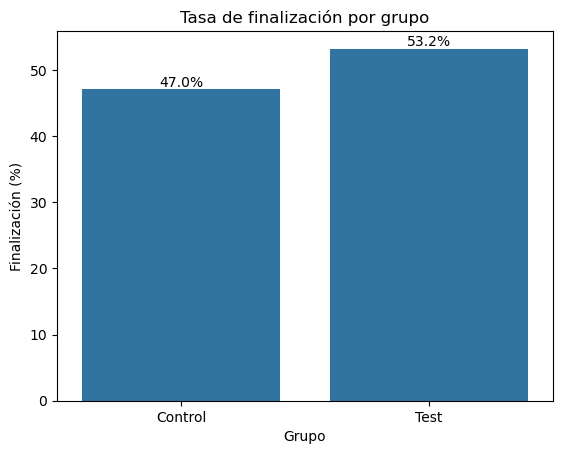

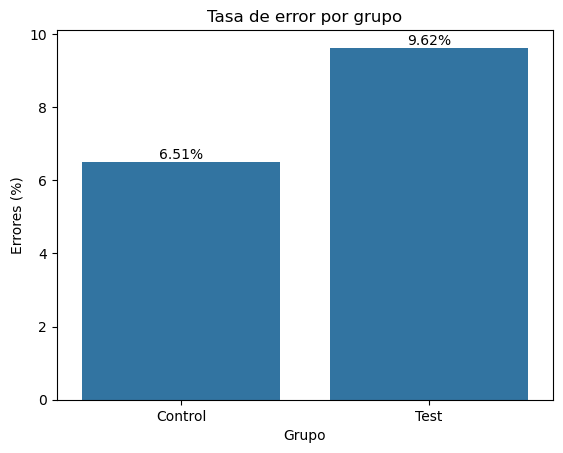

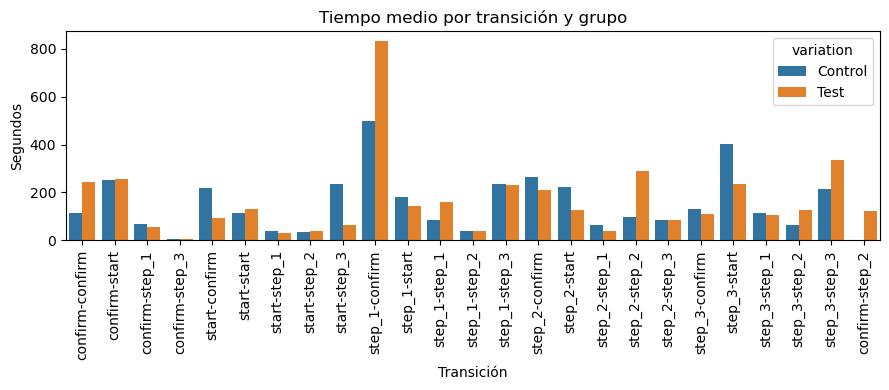

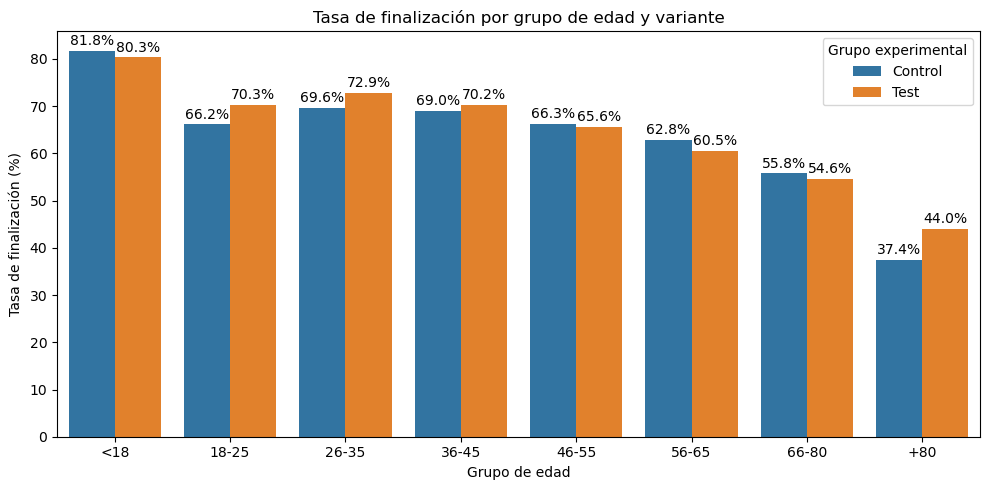

In [16]:
# %%
# 15) Gráficas KPI + tiempos de transición
ax = sns.barplot(data=kpi_final, x='variation', y='tasa_finaliza_porc')
ax.bar_label(ax.containers[0], fmt="%.1f%%")
ax.set_title("Tasa de finalización por grupo"); ax.set_xlabel("Grupo"); ax.set_ylabel("Finalización (%)")
plt.show()

ax = sns.barplot(data=kpi_final, x='variation', y='tasa_error_porc')
ax.bar_label(ax.containers[0], fmt="%.2f%%")
ax.set_title("Tasa de error por grupo"); ax.set_xlabel("Grupo"); ax.set_ylabel("Errores (%)")
plt.show()

plt.figure(figsize=(9,4))
ax = sns.barplot(data=df_tiempos, x='transition', y='media_s', hue='variation')
ax.set_title("Tiempo medio por transición y grupo")
ax.set_xlabel("Transición"); ax.set_ylabel("Segundos")
plt.xticks(rotation=90); plt.tight_layout(); plt.show()
# Tasa de finalización por grupo de edad
# Unimos edad al nivel de visita
df_age_visits = (
    df_visitas.merge(
        df_master[['visita_id','grupo_edad','edad']],
        on='visita_id', how='left'
    )
)
# Calculamos tasa de finalización por grupo de edad y variante
age_conv = (
    df_age_visits.groupby(['grupo_edad','variation'], observed=False)
                 ['finaliza'].mean()
                 .reset_index(name='tasa_finalizacion')
)
# Pasamos a porcentaje
age_conv['tasa_finalizacion_porc'] = (age_conv['tasa_finalizacion'] * 100).round(2)
# Orden lógico de edades (igual que en tu binning)
orden_edades = ['<18','18-25','26-35','36-45','46-55','56-65','66-80','+80']
age_conv['grupo_edad'] = pd.Categorical(age_conv['grupo_edad'], categories=orden_edades, ordered=True)
age_conv = age_conv.sort_values('grupo_edad')
# %%
# Gráfica comparando Control vs Test por grupo de edad
plt.figure(figsize=(10,5))
ax = sns.barplot(
    data=age_conv,
    x='grupo_edad',
    y='tasa_finalizacion_porc',
    hue='variation'
)
ax.bar_label(ax.containers[0], fmt="%.1f%%", label_type="edge", padding=2)
ax.bar_label(ax.containers[1], fmt="%.1f%%", label_type="edge", padding=2)
ax.set_title("Tasa de finalización por grupo de edad y variante")
ax.set_xlabel("Grupo de edad")
ax.set_ylabel("Tasa de finalización (%)")
plt.legend(title="Grupo experimental")
plt.tight_layout()
plt.show()

### Observamos que nos ayuda a mejorar la tasa de finalización en gente menor de 36 años, pero no ayuda en los mayores de 46 que es el grupo con mayor número de usuarios y que además incluye a nuestros clientes primarios ( varones entre 56-80)

# 16) Funnel: último paso alcanzado
Calculamos el **último paso** por visita y dibujamos un gráfico apilado con la distribución de caída/conversión por variante.


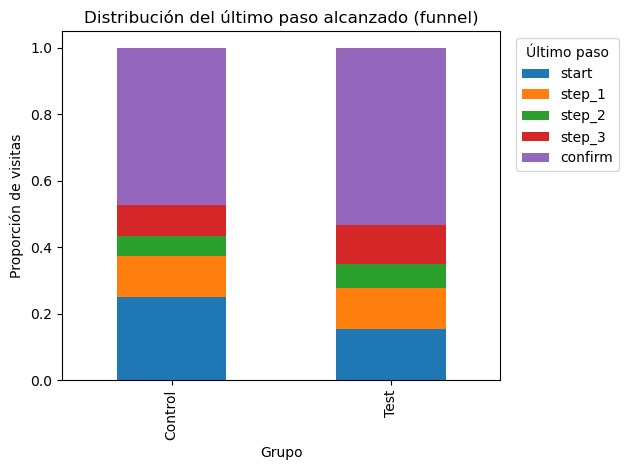

In [17]:
# %%
# 16) Último paso alcanzado (funnel)
ultimo_paso_visita = (
    df_master.sort_values(['visita_id','fecha_hora'])
             .groupby(['visita_id','variation'], as_index=False)
             .agg(ultimo_paso=('estado_proceso','max'))
)

drop_counts = (
    ultimo_paso_visita.value_counts(['variation','ultimo_paso'])
                      .rename('n_visitas').reset_index()
)
totales = drop_counts.groupby('variation')['n_visitas'].sum().rename('n_total')
drop_counts = drop_counts.merge(totales, on='variation', how='left')
drop_counts['pct'] = drop_counts['n_visitas'] / drop_counts['n_total']

pivot_drop = (drop_counts
              .pivot(index='variation', columns='ultimo_paso', values='pct')
              .reindex(columns=orden_pasos, fill_value=0))

pivot_drop.plot(kind='bar', stacked=True)
plt.title("Distribución del último paso alcanzado (funnel)")
plt.xlabel("Grupo"); plt.ylabel("Proporción de visitas")
plt.legend(title='Último paso', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout(); plt.show()


# 17) A/B test — tasas de finalización
Obtenemos proporciones de finalización en `Control` y `Test` para usar en las pruebas estadísticas.


In [18]:
# %%
# 17) A/B test básico: tasas de finalización
grupo_control = df_visitas[df_visitas['variation'] == 'Control']
grupo_test    = df_visitas[df_visitas['variation'] == 'Test']

total_visitas_control = len(grupo_control)
total_visitas_test    = len(grupo_test)

exitos_control = grupo_control['finaliza'].sum()
exitos_test    = grupo_test['finaliza'].sum()

prop_control = exitos_control / total_visitas_control
prop_test    = exitos_test / total_visitas_test

print(f"Control: {prop_control:.4f}")
print(f"Test   : {prop_test:.4f}")


Control: 0.4705
Test   : 0.5320


# 18) Prueba de hipótesis bilateral
Contrastamos si **existe diferencia** en tasas de finalización entre `Control` y `Test` usando un Z-test para dos proporciones (bilateral).


In [19]:
# %%
# 18) Prueba de hipótesis (bilateral)
p_pool = (exitos_control + exitos_test) / (total_visitas_control + total_visitas_test)
se = sqrt(p_pool * (1 - p_pool) * (1/total_visitas_control + 1/total_visitas_test))
z = (prop_test - prop_control) / se
p_valor = 2 * norm.sf(abs(z))

print(f"Z = {z:.3f}")
print(f"P-valor (bilateral) = {p_valor:.6f}")


Z = 12.608
P-valor (bilateral) = 0.000000


# 19) Umbral de +5 puntos porcentuales (unilateral)
Contrastamos si el `Test` **mejora al menos +5 pp** sobre `Control` (prueba **unilateral** contra el umbral objetivo).


In [20]:
# %%
# 19) Umbral de +5 puntos porcentuales (unilateral)
p0 = prop_control + 0.05  # objetivo: Test al menos +5 pp sobre Control
se_thr = sqrt(p0 * (1 - p0) / total_visitas_test)
z_thr = (prop_test - p0) / se_thr
p_valor_thr = norm.sf(z_thr)

print(f"Z umbral = {z_thr:.3f}")
print(f"P-valor (unilateral) = {p_valor_thr:.6f}")


Z umbral = 3.386
P-valor (unilateral) = 0.000354


# 20) Prueba de hipótesis extra: tasa de errores (unilateral)

In [21]:
from statsmodels.stats.proportion import proportions_ztest
# Recuentos de retrocesos y totales
x_test  = error_rate.loc[error_rate['variation'] == 'Test', 'retrocesos'].values[0]
n_test  = error_rate.loc[error_rate['variation'] == 'Test', 'total_eventos'].values[0]
x_ctrl  = error_rate.loc[error_rate['variation'] == 'Control', 'retrocesos'].values[0]
n_ctrl  = error_rate.loc[error_rate['variation'] == 'Control', 'total_eventos'].values[0]
# Hipótesis: H0 = Test tiene igual o más errores; H1 = Test tiene menos errores
z_err, p_err = proportions_ztest([x_test, x_ctrl],
                                 [n_test, n_ctrl],
                                 alternative='smaller')
print(f"Z = {z_err:.3f}")
print(f"P-valor (unilateral) = {p_err:.6f}")
# Conclusión interpretativa
if p_err < 0.05:
    print("Rechazo H₀: el nuevo diseño tiene MENOS errores que el control.")
else:
    print("No hay evidencia suficiente de que el nuevo diseño reduzca errores.")

Z = 25.375
P-valor (unilateral) = 1.000000
No hay evidencia suficiente de que el nuevo diseño reduzca errores.


# 21) Prueba de hipótesis extra: tiempo medio por visita

In [22]:
from scipy.stats import mannwhitneyu
t_control = grupo_control['t_total']
t_test    = grupo_test['t_total']
stat_t, p_t = mannwhitneyu(t_test, t_control, alternative='less')  # unilateral (test < control)
print(f"U = {stat_t:.1f}")
print(f"P-valor (unilateral) = {p_t:.6f}")
if p_t < 0.05:
    print("Rechazo H₀: el nuevo diseño reduce el tiempo total por visita.")
else:
    print("No hay evidencia de que el nuevo diseño sea más rápido.")

U = 244616556.0
P-valor (unilateral) = 1.000000
No hay evidencia de que el nuevo diseño sea más rápido.


## Insights y conclusiones finales:
### - **Efectividad del diseño**: 
 - Hemos logrado más confirms y hemos resuelto parte del problema en el primer paso, pero esto último se ve reflejado también en un aumento de usuarios que se quedan entre el paso "step_1" y "step_3".
 - Observamos que nos ayuda a mejorar la tasa de finalización en gente menor de 36 años, pero no ayuda en los mayores de 46 que es el grupo con mayor número de usuarios y que además incluye a nuestros clientes primarios (varones entre 56-80 años).
 - No hay evidencia de mejora en los errores, de hecho aumenta un 3%.
 - Tampoco hay evidencia de que el nuevo diseño sea más rápido.
### - **Duración** : 
 - Para acabar de confirmar que start ha reducido errores, el experimento debería haber durado más tiempo para recopilar más datos y sacar mejores conclusiones.
### - **Datos adicionales**: 
 - Para poder valorar la satisfacción del usuario, deberíamos implementar un test de valoración cuando el usuario haya iniciado sesión un par de veces en la aplicación, y así valorar si ha sido mejor o peor la experiencia. (Dependiendo de si es control o test).
 - Tipo de dispositivo usado para ver si tiene relación con el número de errores.

## Insights y conclusiones finales
### **Efectividad del diseño**
- El nuevo diseño (Test) logra una **mayor tasa de finalización global** respecto al Control, aunque la mejora es modesta.
- La mejora se concentra en **usuarios jóvenes (<36 años)**, donde la tasa de confirmación aumenta significativamente.
- En cambio, **no se observan mejoras** en el grupo **mayor de 46 años**, que representa **nuestro público principal (50–80+)**.
  Esto sugiere que el rediseño puede no estar bien adaptado a las necesidades de usuarios senior (usabilidad, legibilidad o pasos de validación).
- No hay evidencia de reducción en la tasa de errores; incluso aumenta ligeramente (3%), lo que podría indicar más confusión con el nuevo diseño.
- Tampoco hay evidencia de que el nuevo diseño sea más rápido (p > 0.05 en la prueba Mann-Whitney).
### **Duración del experimento**
- La prueba abarca 15/03/2017 – 20/06/2017 (~3 meses), tiempo suficiente para obtener una muestra representativa.
- Aun así, sería recomendable extender el periodo o repetir el test en distintos momentos del año para validar estabilidad temporal.
### **Datos adicionales recomendados**
- Incluir variables de **dispositivo, navegador y canal de entrada** para entender si la experiencia varía entre móvil y escritorio.
- Implementar un **test de valoración UX** (encuesta post-sesión o Net Promoter Score) para medir percepción subjetiva.
- Registrar **eventos de interacción** (clicks, campos con error, scroll, ayuda usada) para detectar fricción dentro del flujo.
- Añadir **métricas de negocio** (retención, llamadas al soporte, contratación posterior) para traducir la mejora en impacto económico.
---
> *Conclusión general:* El nuevo diseño mejora parcialmente la conversión, pero **no beneficia al segmento senior**, que es el más relevante para el negocio.
> Se recomienda una iteración centrada en accesibilidad y simplicidad para usuarios de 50–80+ años antes del despliegue definitivo.